In [2]:
import pandas as pd
import re
import emoji
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, classification_report
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("dataItalian.csv")

def clean_text(text):
    if pd.isnull(text):
        return ""
    text = str(text)

    text = re.sub(r"http\S+|www\.\S+", "", text)

    text = emoji.replace_emoji(text, replace='')

    text = "\n".join([line for line in text.splitlines() if line.strip() != ""])

    return text.strip()

df['review_text'] = df['review_text'].apply(clean_text)

print(f"Dataset pulito ({len(df)} righe).")

Dataset pulito (166968 righe).


In [5]:
label_map = {1.0: 0.0, 2.0: 0.25, 3.0: 0.50, 4.0: 0.75, 5.0: 1.0}
df['labels'] = df['review_stars'].map(label_map)

print(df['labels'].value_counts())

labels
1.00    108016
0.00     32119
0.75     18558
0.50      4763
0.25      3512
Name: count, dtype: int64


In [6]:
class_counts = df['labels'].value_counts()
min_count = class_counts.min()

print("Numero target per classe:", min_count)

# Downsample ogni classe
df = pd.concat([resample(df[df['labels'] == label], replace=False, n_samples=min_count, random_state=42)
    for label in class_counts.index
])

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(df['labels'].value_counts())

Numero target per classe: 3512
labels
0.50    3512
1.00    3512
0.75    3512
0.25    3512
0.00    3512
Name: count, dtype: int64


In [7]:
dataset = Dataset.from_pandas(df)
dataset = dataset.train_test_split(test_size=0.3, seed=42)
splitValidation = dataset['test'].train_test_split(test_size=0.5, seed=42)

dataset = DatasetDict({
    'train': dataset['train'],
    'test': splitValidation['train'],
    'validation': splitValidation['test']
})

print("Train size:", len(dataset['train']))
print("Test size:", len(splitValidation['train']))
print("Validation size:", len(splitValidation['test']))

Train size: 12292
Test size: 2634
Validation size: 2634


In [8]:
MODEL = "dbmdz/bert-base-italian-xxl-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

def tokenize(batch):
    return tokenizer(batch['review_text'], padding='max_length', truncation=True, max_length=512)

dataset = dataset.map(tokenize, batched=True)

model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=1, problem_type="regression")

print(torch.cuda.is_available())

Map: 100%|██████████| 2634/2634 [00:00<00:00, 3938.38 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-italian-xxl-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


True


In [24]:
def compute_metrics(eval_pred):
    preds = eval_pred.predictions.squeeze()
    labels = eval_pred.label_ids
    return {
        "mse": mean_squared_error(labels, preds),
        "mae": mean_absolute_error(labels, preds),
        "r2": r2_score(labels, preds)
    }

def collate_fn(batch):
    return {
        "input_ids": torch.tensor([x['input_ids'] for x in batch]),
        "attention_mask": torch.tensor([x['attention_mask'] for x in batch]),
        "labels": torch.tensor([x['labels'] for x in batch], dtype=torch.float)
    }

training_args = TrainingArguments(
    output_dir="./sentiment_regression",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    logging_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=2e-5,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',
    fp16=True, #solo su NVIDIA
    gradient_accumulation_steps=8,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    processing_class=tokenizer,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

Epoch,Training Loss,Validation Loss,Mse,Mae,R2
1,0.045600,0.031330,0.031330,0.134902,0.747506
2,0.027300,0.029241,0.029241,0.128033,0.764342
3,0.021100,0.027957,0.027957,0.128308,0.774691
4,0.016300,0.031332,0.031332,0.132238,0.747483
5,0.012700,0.029596,0.029596,0.129294,0.761478


TrainOutput(global_step=1925, training_loss=0.024605004446847097, metrics={'train_runtime': 1875.0289, 'train_samples_per_second': 65.556, 'train_steps_per_second': 2.053, 'total_flos': 1.617066027128832e+16, 'train_loss': 0.024605004446847097, 'epoch': 5.0})


Valutazione sul Test Set


MSE: 0.0280
MAE: 0.1283
R²: 0.7747


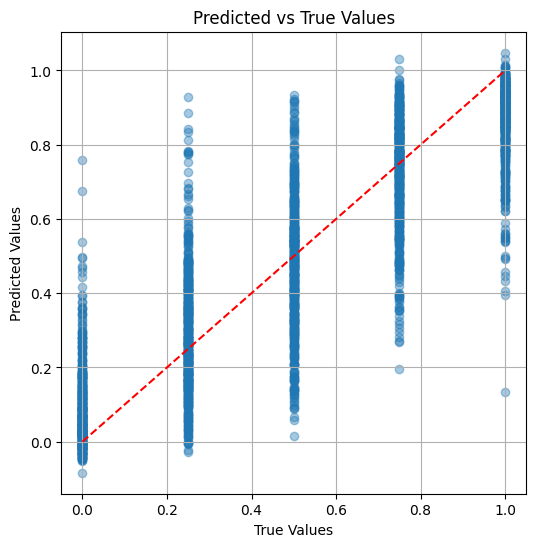

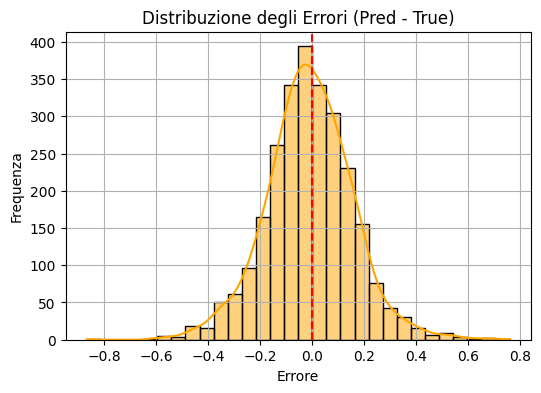

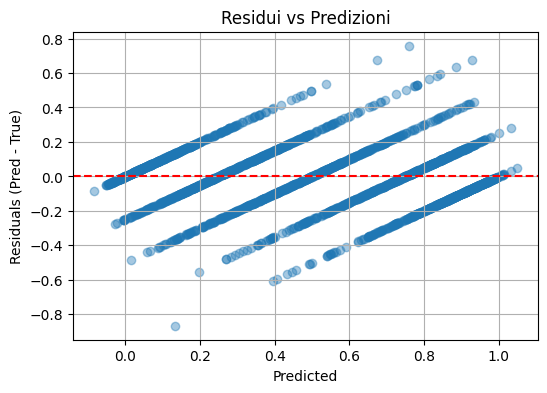

In [35]:
print("\nValutazione sul Test Set")
predictions = trainer.predict(dataset['test'])
y_true = predictions.label_ids
y_pred = predictions.predictions.squeeze()

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# Predicted vs True scatter plot
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.4)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs True Values")
plt.grid(True)
plt.show()

# Distribuzione degli errori (residui)
errors = y_pred - y_true
plt.figure(figsize=(6,4))
sns.histplot(errors, bins=30, kde=True, color='orange')
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribuzione degli Errori (Pred - True)")
plt.xlabel("Errore")
plt.ylabel("Frequenza")
plt.grid(True)
plt.show()

# Residui vs Predizioni
plt.figure(figsize=(6,4))
plt.scatter(y_pred, errors, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals (Pred - True)")
plt.title("Residui vs Predizioni")
plt.grid(True)
plt.show()


Valutazione sul Validation Set


MSE: 0.0260
MAE: 0.1234
R²: 0.7810


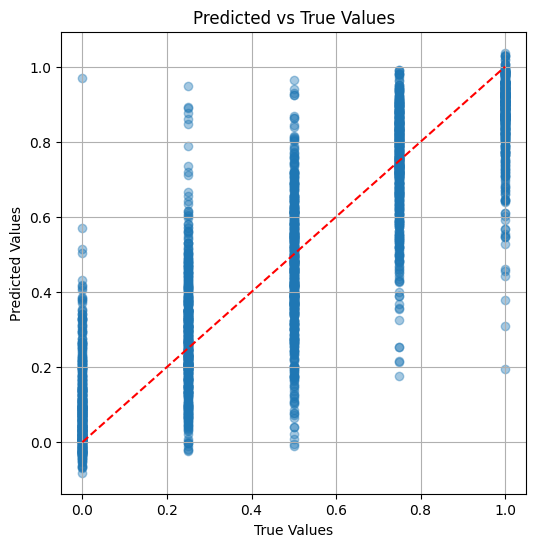

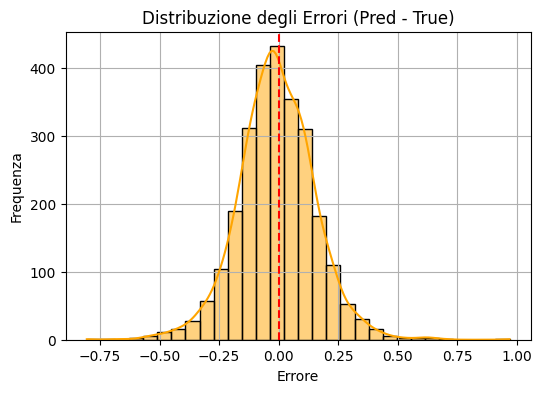

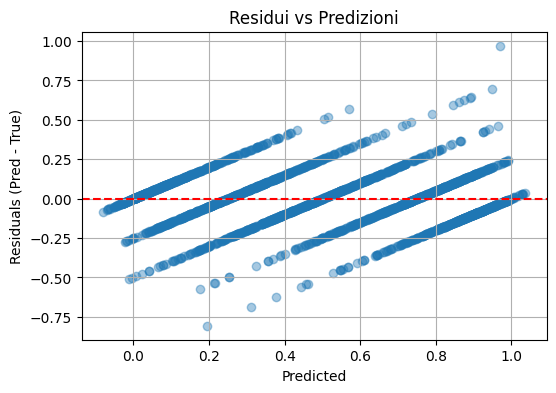

In [36]:
print("\nValutazione sul Validation Set")
predictions = trainer.predict(dataset['validation'])
y_true = predictions.label_ids
y_pred = predictions.predictions.squeeze()

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# Predicted vs True scatter plot
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.4)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs True Values")
plt.grid(True)
plt.show()

# Distribuzione degli errori (residui)
errors = y_pred - y_true
plt.figure(figsize=(6,4))
sns.histplot(errors, bins=30, kde=True, color='orange')
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribuzione degli Errori (Pred - True)")
plt.xlabel("Errore")
plt.ylabel("Frequenza")
plt.grid(True)
plt.show()

# Residui vs Predizioni
plt.figure(figsize=(6,4))
plt.scatter(y_pred, errors, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals (Pred - True)")
plt.title("Residui vs Predizioni")
plt.grid(True)
plt.show()

In [27]:
model.save_pretrained("./sentiment_model")
tokenizer.save_pretrained("./sentiment_model")

('./sentiment_model/tokenizer_config.json',
 './sentiment_model/special_tokens_map.json',
 './sentiment_model/vocab.txt',
 './sentiment_model/added_tokens.json',
 './sentiment_model/tokenizer.json')

In [5]:
MODEL_DIR = "./sentiment_model"
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
model.eval()

text = "ciao brutta app"

inputs = tokenizer(text, return_tensors="pt")

outputs = model(**inputs)
score = outputs.logits.squeeze().item()

print("Valore predetto (regressione):", score)

c:\Users\ruggi\Desktop\finale\.venv-1\Lib\site-packages\torch\nn\modules\module.py:1784: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Valore predetto (regressione): 0.10825973004102707
